In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
from mpl_toolkits import mplot3d
from scipy.stats import spearmanr
import collections
import feather
from scipy import stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import regionmask
import xesmf

import sys
sys.path.append('../')
import utils
import plotting


# Import Data

In [2]:
models = ['normal_model','nonuc_model','no_coal','nox_lim']
pollutants = ['NO','NO2','SO2','CO2','CH4']

regionname_grouped_ds = xr.open_zarr(f'./final_data/regionname_grouped_emissions_ds.zarr')
fueltype_grouped_ds = xr.open_zarr(f'./final_data/fueltype_grouped_emissions_ds.zarr')
gmodel_egrid_ds = xr.open_zarr(f'./final_data/gmodel_egrid_emissions_ds.zarr')
oris_nonuc_ds = xr.open_zarr(f'./final_data/oris_nonuc_ds.zarr')

In [3]:
region_season = utils.season_mean(regionname_grouped_ds.rename({'date':'time'}))
fuel_season = utils.season_mean(fueltype_grouped_ds.rename({'date':'time'}))


In [4]:
convert_NO_N = 14.01/30.01
convert_NO2_N = 14.01/46.01
gmodel_egrid_ds['model_annual_NOx_conc'] = (gmodel_egrid_ds['model_annual_NO_conc']*convert_NO_N+
                                               gmodel_egrid_ds['model_annual_NO2_conc']*convert_NO2_N)

In [155]:
#total number of plants with emissions factors above the mean
for poll in ['CO2','NOX','SO2']:
    print(poll)
    threshold = gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'].std().values
    print(model, ': plants ', gmodel_egrid_ds.sel(model_name = 'normal_model').where(gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'] >threshold, drop = True)['ORISCode'].count().values)

CO2
nonuc_nocoal_model : plants  29
NOX
nonuc_nocoal_model : plants  16
SO2
nonuc_nocoal_model : plants  19


In [5]:
#number of plants with emissions factors above the mean being turned on
for poll in ['CO2','NOX','SO2']:
    print(poll)
    for model in ['nonuc_model', 'normal_model', 'nonuc_nocoal_model']:
        threshold = gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].std().values
        
        print(model, ': plants ', gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['ORISCode'].count().values, 'total generation',
             gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['annual_modelgeneration'].sum().values)
        print('percent of generation from dirtiest plants: ', 100*(gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['annual_modelgeneration'].sum().values/
                                                                         gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'].sum().values))
        if poll == 'NOX':
            poll2 = 'NOx'
        else: 
            poll2 = poll
        print(f'percent of {poll} emissions from dirtiest plants: ', 100*(gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)[f'model_annual_{poll2}_conc'].sum().values/
                                                                         gmodel_egrid_ds.sel(model_name = model)[f'model_annual_{poll2}_conc'].sum().values))
        print(f'{poll} emissions from dirtiest plants: ', (gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)[f'model_annual_{poll2}_conc'].sum().values))

CO2
nonuc_model : plants  2 total generation 2516246.4282249594
percent of generation from dirtiest plants:  0.06163686614684046
percent of CO2 emissions from dirtiest plants:  2.7942923196937364
CO2 emissions from dirtiest plants:  70809681516.82516
normal_model : plants  2 total generation 259918.36147872606
percent of generation from dirtiest plants:  0.006367644548933354
percent of CO2 emissions from dirtiest plants:  0.4059315316861807
CO2 emissions from dirtiest plants:  7314066205.803219
nonuc_nocoal_model : plants  27 total generation 7720287.915545878
percent of generation from dirtiest plants:  0.1887074257079519
percent of CO2 emissions from dirtiest plants:  13.111813027344017
CO2 emissions from dirtiest plants:  249174899983.30487
NOX
nonuc_model : plants  1 total generation 17520.0
percent of generation from dirtiest plants:  0.0004291622166968858
percent of NOX emissions from dirtiest plants:  0.15061346199475567
NOX emissions from dirtiest plants:  1145568.0344484546
no

In [6]:
model = 'normal_model'
poll = 'CO2'
threshold = gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].std().values
plants_interest = (gmodel_egrid_ds.sel(model_name = model).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['ORISCode']).values

(-100.0, 200.0)

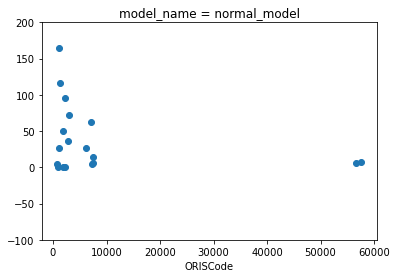

In [7]:
(gmodel_egrid_ds.where(gmodel_egrid_ds['ORISCode'].isin(plants_interest), drop =True)['annual_egridgeneration'].sel(model_name = 'normal_model')-
    gmodel_egrid_ds.where(gmodel_egrid_ds['ORISCode'].isin(plants_interest), drop =True)['annual_modelgeneration'].sel(model_name = 'normal_model')).plot(linestyle = 'None', marker = 'o')
plt.ylim(-100,200)

In [156]:
for poll in ['CO2','NOX','SO2']:
    print(poll)
    for model in ['nonuc_model', 'normal_model', 'nonuc_nocoal_model']:
        threshold = gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].std().values
        print(model, ': plants ', gmodel_egrid_ds.sel(model_name = model).where(
    gmodel_egrid_ds.sel(model_name = model)['annual_modelgeneration'] > 0., drop = True).where(gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'] >threshold, drop = True)['fueltype'].values)

CO2
nonuc_model : plants  ['Coal' 'NaturalGas']
normal_model : plants  ['Coal' 'NaturalGas']
nonuc_nocoal_model : plants  ['Oil' 'Oil' 'NaturalGas' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'NaturalGas'
 'Oil' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'NaturalGas' 'NaturalGas'
 'NaturalGas' 'Oil' 'Oil' 'Oil' 'Oil' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'Oil'
 'Oil' 'NaturalGas']
NOX
nonuc_model : plants  ['Non-Fossil']
normal_model : plants  ['Non-Fossil']
nonuc_nocoal_model : plants  ['Oil' 'Oil' 'Oil' 'NaturalGas' 'NaturalGas' 'Oil' 'NaturalGas' 'Oil'
 'NaturalGas' 'Oil' 'Oil' 'Oil' 'Oil' 'Oil' 'Non-Fossil']
SO2
nonuc_model : plants  ['Coal' 'Coal' 'Coal' 'Coal' 'Coal' 'Coal' 'Coal' 'Non-Fossil']
normal_model : plants  ['Coal' 'Coal' 'Coal' 'Coal' 'Non-Fossil']
nonuc_nocoal_model : plants  ['Oil' 'Oil' 'NaturalGas' 'Oil' 'Oil' 'Oil' 'Oil' 'Oil' 'NaturalGas' 'Oil'
 'NaturalGas' 'Oil' 'Oil' 'NaturalGas' 'Non-Fossil']


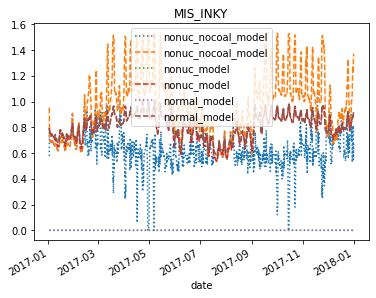

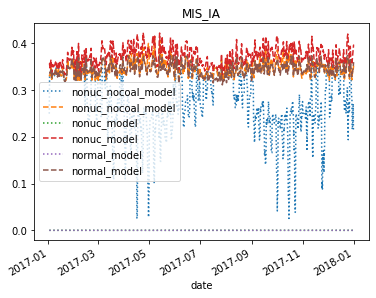

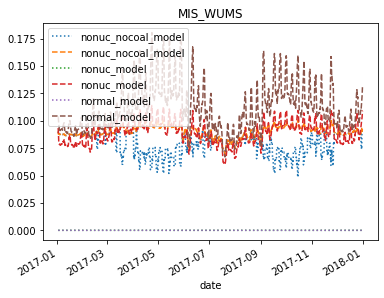

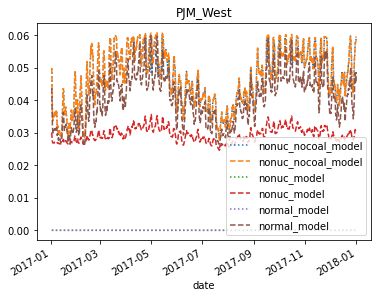

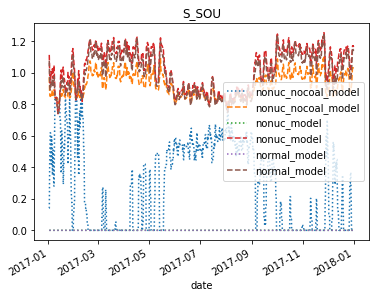

In [105]:
#plot the % of the region's energy produced by highest emitters
for idx, ors in enumerate(gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model)['ORISCode'].values):
    fig, ax = plt.subplots()
    region = gmodel_egrid_ds.sel(ORISCode = ors, model_name = 'nonuc_model')['regionname'].values
    for model in [ 'nonuc_nocoal_model','nonuc_model', 'normal_model']:
        ((gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model, ORISCode = ors)['modelgeneration']/
         gmodel_egrid_ds.where( 
                    gmodel_egrid_ds.regionname == gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, 
                                                                           drop = True).sel(model_name = model, 
                                                                                            ORISCode = ors)['regionname'].values).sel(model_name = model)['modelgeneration'].sum(dim = 'ORISCode')).rolling(date = 24).mean()*100).plot(linestyle = 'dotted', label = model)
        
        ((gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, drop = True).sel(model_name = model, ORISCode = ors)['Capacity']/
 gmodel_egrid_ds.where( 
            gmodel_egrid_ds.regionname == gmodel_egrid_ds.where(gmodel_egrid_ds['PLNOXRTA'] >threshold, 
                                                                   drop = True).sel(model_name = model, 
                                                                                    ORISCode = ors)['regionname'].values).sel(model_name = model)['modelgeneration'].sum(dim = 'ORISCode')).rolling(date = 24).mean()*100).plot(linestyle = 'dashed', label = model)
        
        plt.legend(loc = 'best')
        plt.title(region)

generation change [-5.00000000e+00 -1.00000000e+00 -1.65000000e+02 -2.60020000e+01
 -1.17001000e+02 -7.44000000e+02 -1.43400000e+03 -5.00000000e+01
 -1.00000000e+00 -1.31700000e+03 -9.60000000e+01 -1.00000000e+00
  2.57852361e+05 -3.74000000e+02 -3.60000000e+01 -6.79000000e+02
 -7.20000000e+01 -2.70020000e+01             nan -6.30000000e+01
 -5.00100000e+00 -5.99900000e+00 -1.40000000e+01             nan
             nan -6.00000000e+00             nan -7.00000000e+00
             nan]
percent change [ -100.          -100.          -100.          -100.
  -100.          -100.          -100.          -100.
  -100.          -100.          -100.          -100.
 13818.45452726  -100.          -100.          -100.
  -100.          -100.                    nan  -100.
  -100.          -100.          -100.                    nan
            nan  -100.                    nan  -100.
            nan]


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


generation change [-5.00000e+00 -1.00000e+00 -2.60020e+01 -1.17001e+02 -5.00000e+01
 -1.00000e+00 -9.60000e+01 -1.00000e+00 -7.20000e+01 -2.70020e+01
 -5.00100e+00 -5.99900e+00 -6.00000e+00          nan -7.00000e+00
  1.73900e+04]
percent change [ -100.          -100.          -100.          -100.
  -100.          -100.          -100.          -100.
  -100.          -100.          -100.          -100.
  -100.                    nan  -100.         13376.92307692]


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


generation change [-5.00000000e+00 -1.00000000e+00 -1.23210000e+04  5.05563000e+05
 -2.60020000e+01 -7.44000000e+02 -1.00000000e+00 -1.00000000e+00
 -3.74000000e+02 -4.61510000e+04  7.72870000e+04 -1.03970000e+04
 -7.20000000e+01 -2.70020000e+01 -5.00100000e+00 -3.13005777e+05
  1.36498000e+05             nan  7.77545000e+03]
percent change [-100.         -100.         -100.          791.95920861 -100.
 -100.         -100.         -100.         -100.         -100.
   41.66123129 -100.         -100.         -100.         -100.
  -99.99769258   54.83124583           nan  789.74658473]


/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


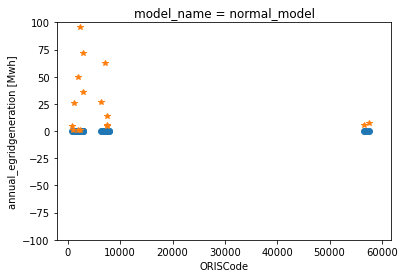

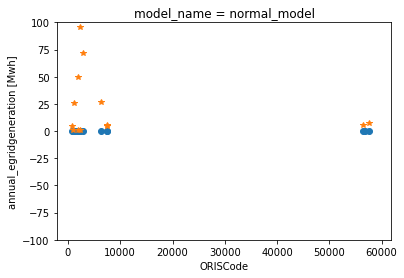

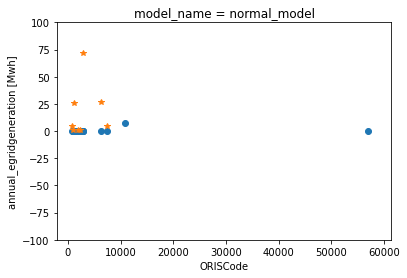

In [33]:
for poll in ['CO2','NOX','SO2']:
    fig, ax = plt.subplots()
    threshold = gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].mean().values + gmodel_egrid_ds.sel(model_name = model)[f'PL{poll}RTA'].std().values

    gmodel_egrid_ds.sel(model_name = 'normal_model')['annual_modelgeneration'].where(
        gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'] >threshold, drop = True).plot(marker = 'o', linestyle = 'None')

    gmodel_egrid_ds.sel(model_name = 'normal_model')['annual_egridgeneration'].where(
        gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'] >threshold, drop = True).plot(marker = '*', linestyle = 'None')
    plt.ylim(-100,100)

    print('generation change', ((gmodel_egrid_ds.sel(model_name = 'normal_model')['annual_modelgeneration']-
     gmodel_egrid_ds.sel(model_name = 'normal_model')['annual_egridgeneration'])).where(
        gmodel_egrid_ds.sel(model_name = 'normal_model')[f'PL{poll}RTA'] >threshold, drop = True).values)